In [1]:
# Group 8
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from statsmodels.tsa.seasonal import seasonal_decompose

## Import data 

In [2]:
if not os.path.exists("cache"):
    os.makedirs("cache")

dump_path = "cache/raw_data.pkl"

if os.path.exists(dump_path):
    [acti, prod] = pickle.load(open(dump_path, 'rb')) # load data
else:
    acti = pd.read_csv('data/Activity.csv', engine='python')
    prod = pd.read_csv('data/Product.csv', engine='python')
    pickle.dump([acti, prod], open(dump_path, 'wb')) # save data

In [3]:
# drop useless columns
acti = acti.drop(['IPC Flag', 'Cust ID', 'ASIN', 'Article', 'Style Desc'], axis=1)
prod = prod[['SKU[UPC]', 'Article[Style Num]', 'Article[Reporting Business Unit]', 'Article[Main Color Group Desc]',
             'Article[Style Family]', 'SKU[Length (in)]', 'SKU[Width (in)]', 'SKU[Height (in)]', 'SKU[Weight (g)]']]

In [4]:
acti.columns = acti.columns.str.replace(" ", "_")

new_name = ['UPC', 'Style_Num', 'Reporting_Business_Unit','Main_Color_Group_Desc',
            'Style_Family','Length_in','Width_in','Height_in', 'Weight_g']
prod = prod.rename(columns = dict(zip(prod.columns, new_name)))

In [5]:
acti.info()
prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2065014 entries, 0 to 2065013
Data columns (total 14 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   ERP_Combined_Start_Fiscal_Year  int64  
 1   ERP_Combined_Start_Fiscal_Week  int64  
 2   Product_Division                object 
 3   ERP_Gender                      object 
 4   ERP_Master_Gender               object 
 5   ERP_Season_Cd_Opened            int64  
 6   UPC                             int64  
 7   US_Size                         object 
 8   ERP_Ooh_Qty                     float64
 9   ERP_Ooh                         float64
 10  ERP_Cancel_Qty                  float64
 11  ERP_Cancel                      float64
 12  ERP_Sls_Qty                     float64
 13  ERP_Sls                         float64
dtypes: float64(6), int64(4), object(4)
memory usage: 220.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660951 entries, 0 to 660950
Data columns (total 9 col

In [6]:
# data merge
df = pd.merge(acti, prod, how='left', on='UPC')

In [7]:
# convert year and week to datetime
df['Year_Week'] = pd.to_datetime(df['ERP_Combined_Start_Fiscal_Year'].astype(str) + ' ' + 
                                 df['ERP_Combined_Start_Fiscal_Week'].astype(str) + ' 1', format='%Y %U %w')

## Data cleaning

In [8]:
dump_path = "cache/cleaned_data.pkl"

if os.path.exists(dump_path):
    df = pickle.load(open(dump_path, 'rb')) # load cleaned data
else:
    # fill nan with 0
    fill_list = acti.columns[8:14]
    for col in fill_list:
        df[col] = df[col].fillna(0)

    # drop rows where 'reporting_business_unit' == nan
    df = df[df['Reporting_Business_Unit'].notna()]

    # replace "Running" and "Training & Fitness" to "Run/Train" in column 'Reporting_Business_Unit'
    df['Reporting_Business_Unit'].replace(['Running', 'Training & Fitness'], ['Run/Train', 'Run/Train'], inplace = True)

    # fill nan in "Main_Color_Group_Desc" and "Style_Family"
    df['Main_Color_Group_Desc'] = df['Main_Color_Group_Desc'].fillna("unknown")
    df['Style_Family'] = df['Style_Family'].fillna("unknown")
    
    # calculate the total qty and value
    df['Total_Ordered_Qty'] = df['ERP_Ooh_Qty'] + df['ERP_Cancel_Qty'] + df['ERP_Sls_Qty']
    df['Total_Ordered_Value'] = df['ERP_Ooh'] + df['ERP_Cancel'] + df['ERP_Sls']
    
    pickle.dump(df, open(dump_path, 'wb')) # save cleaned data

In [9]:
df.isna().sum()

ERP_Combined_Start_Fiscal_Year    0
ERP_Combined_Start_Fiscal_Week    0
Product_Division                  0
ERP_Gender                        0
ERP_Master_Gender                 0
ERP_Season_Cd_Opened              0
UPC                               0
US_Size                           0
ERP_Ooh_Qty                       0
ERP_Ooh                           0
ERP_Cancel_Qty                    0
ERP_Cancel                        0
ERP_Sls_Qty                       0
ERP_Sls                           0
Style_Num                         0
Reporting_Business_Unit           0
Main_Color_Group_Desc             0
Style_Family                      0
Length_in                         0
Width_in                          0
Height_in                         0
Weight_g                          0
Year_Week                         0
Total_Ordered_Qty                 0
Total_Ordered_Value               0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2064371 entries, 0 to 2065013
Data columns (total 25 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   ERP_Combined_Start_Fiscal_Year  int64         
 1   ERP_Combined_Start_Fiscal_Week  int64         
 2   Product_Division                object        
 3   ERP_Gender                      object        
 4   ERP_Master_Gender               object        
 5   ERP_Season_Cd_Opened            int64         
 6   UPC                             int64         
 7   US_Size                         object        
 8   ERP_Ooh_Qty                     float64       
 9   ERP_Ooh                         float64       
 10  ERP_Cancel_Qty                  float64       
 11  ERP_Cancel                      float64       
 12  ERP_Sls_Qty                     float64       
 13  ERP_Sls                         float64       
 14  Style_Num                       float64       
 15

In [11]:
df.iloc[:,0:14].head()

,ERP_Combined_Start_Fiscal_Year,ERP_Combined_Start_Fiscal_Week,Product_Division,ERP_Gender,ERP_Master_Gender,ERP_Season_Cd_Opened,UPC,US_Size,ERP_Ooh_Qty,ERP_Ooh,ERP_Cancel_Qty,ERP_Cancel,ERP_Sls_Qty,ERP_Sls
0,2022,15,Apparel,MNS,MNS,20213,194580280119,XXL,2.0,65.00,1.0,32.5,0.0,0.0
1,2022,15,Footwear,WNS,WNS,20191,192340698204,7,1.0,16.50,0.0,0.0,0.0,0.0
2,2022,15,Footwear,WNS,WNS,20191,192340682746,9.5,1.0,35.75,0.0,0.0,0.0,0.0
3,2022,15,Apparel,MNS,MNS,20203,194577192463,XLT,25.0,312.50,0.0,0.0,0.0,0.0
4,2022,15,Apparel,MNS,MNS,20203,194577192562,2XL,21.0,262.50,0.0,0.0,0.0,0.0


In [12]:
df.iloc[:,14:26].head()

,Style_Num,Reporting_Business_Unit,Main_Color_Group_Desc,Style_Family,Length_in,Width_in,Height_in,Weight_g,Year_Week,Total_Ordered_Qty,Total_Ordered_Value
0,531190.0,Motorsport,black,unknown,7.1,8.7,0.4,335.0,2022-04-11,3.0,97.50
1,371013.0,Sportstyle Core,black,Cool Cat,0.0,0.0,0.0,0.0,2022-04-11,1.0,16.50
2,370325.0,Sportstyle Core,white,Carina,11.8,7.3,4.3,890.0,2022-04-11,1.0,35.75
3,586446.0,Sportstyle Core,white,unknown,13.4,11.0,3.1,300.0,2022-04-11,25.0,312.50
4,586446.0,Sportstyle Core,black,unknown,13.4,11.0,3.1,300.0,2022-04-11,21.0,262.50


## EDA

In [14]:
grouped_division = df.groupby(['Product_Division'])
grouped_division['Total_Ordered_Qty'].sum()

Product_Division
Accessories      37249.0
Apparel        2660934.0
Footwear       6019736.0
Name: Total_Ordered_Qty, dtype: float64

In [15]:
grouped_open = df[df['Product_Division'] == 'Footwear'].groupby(['ERP_Master_Gender'])
grouped_open['Total_Ordered_Qty'].sum().sort_values(ascending=False)

ERP_Master_Gender
MNS     2977221.0
KIDS    1584518.0
WNS     1457997.0
Name: Total_Ordered_Qty, dtype: float64

In [16]:
pd.crosstab(df['Product_Division'], df['ERP_Master_Gender'], 
            values = df['Total_Ordered_Qty'], aggfunc='sum').round(0)

ERP_Master_Gender,KIDS,MNS,WNS
Product_Division,,,
Accessories,NaN,36749.0,500.0
Apparel,22448.0,1722747.0,915739.0
Footwear,1584518.0,2977221.0,1457997.0


In [17]:
grouped_open = df[df['Product_Division'] == 'Footwear'].groupby(['Style_Family'])
grouped_open['Total_Ordered_Qty'].sum().sort_values(ascending=False).head(20)

Style_Family
Tazon                922964.0
ST Runner            371179.0
Roma                 355521.0
Smash                339939.0
Cool Cat             328965.0
Popcat               247107.0
Carina               231029.0
Overlasted 10cell    195253.0
Cabana               191720.0
Enzo                 165359.0
Prowl                128587.0
Pacer                126286.0
Rebound              120369.0
Softride             103888.0
Standalones           84694.0
California            77769.0
Super Elevate         75512.0
Drift Cat             69626.0
10cell                67091.0
Leadcat               59943.0
Name: Total_Ordered_Qty, dtype: float64

In [18]:
grouped_open = df[df['Product_Division'] == 'Footwear'].groupby(['Reporting_Business_Unit'])
grouped_open['Total_Ordered_Qty'].sum().sort_values(ascending=False)

Reporting_Business_Unit
Run/Train                    1957860.0
Sportstyle Core              1611840.0
Sportstyle Kids              1448879.0
Sportstyle Prime / Select     618506.0
Teamsport                     214778.0
Motorsport                    146652.0
Basketball                      7607.0
Lifestyle                       7073.0
Fundamentals                    3964.0
Esports                         2561.0
Ecosphere                         16.0
Name: Total_Ordered_Qty, dtype: float64

In [19]:
pd.crosstab(df['Reporting_Business_Unit'], df['ERP_Master_Gender'], 
            values = df['Total_Ordered_Qty'], aggfunc='sum').round(0)

ERP_Master_Gender,KIDS,MNS,WNS
Reporting_Business_Unit,,,
Accessories,NaN,274.0,478.0
Basketball,1775.0,13451.0,NaN
Ecosphere,NaN,16.0,NaN
Esports,NaN,6654.0,359.0
Fundamentals,3370.0,2104.0,3170.0
Licensing,NaN,2445.0,98.0
Lifestyle,532.0,5066.0,2867.0
Motorsport,29723.0,286686.0,6434.0
Other Business,NaN,6190.0,NaN


In [20]:
grouped_open = df[df['Product_Division'] == 'Footwear'].groupby(['US_Size'])
grouped_open['Total_Ordered_Qty'].sum().sort_values(ascending=False).head(20)

US_Size
9       605783.0
10      556027.0
8       517286.0
11      454203.0
7       443166.0
10.5    353995.0
8.5     339749.0
9.5     328871.0
12      324908.0
13      272966.0
6       266846.0
7.5     255198.0
11.5    190214.0
6.5     159463.0
5       152093.0
4       129453.0
5.5     112207.0
14      106352.0
1        77286.0
2        52885.0
Name: Total_Ordered_Qty, dtype: float64

In [21]:
grouped_open = df[df['Product_Division'] == 'Footwear'].groupby(['Main_Color_Group_Desc'])
grouped_open['Total_Ordered_Qty'].sum().sort_values(ascending=False)

Main_Color_Group_Desc
black               2571057.0
white               1503030.0
blue                 584472.0
gray                 513984.0
pink                 327563.0
red                  235022.0
green                 79589.0
beige                 44581.0
purple                44330.0
yellow                41573.0
Assorted Colours      24554.0
orange                18707.0
brown                 14105.0
unknown               12156.0
metallic               3341.0
gold                   1004.0
silver                  643.0
translucent              21.0
not defined               4.0
Name: Total_Ordered_Qty, dtype: float64

In [22]:
def order_ts(cond1, val1, cond2, val2):
    if cond2 == '':
        ts = df[df[cond1] == val1]
        title = 'Total Ordered Qty of ' + val1
    else:
        ts = df[(df[cond1] == val1) & (df[cond2] == val2)]
        title = 'Total Ordered Qty of ' + val1 + ' x ' + val2
    ts = ts.groupby(['Year_Week'])['Total_Ordered_Qty'].sum()

    plt.figure(figsize = (20,5))
    plt.plot(ts)
    plt.title(title)
    plt.ylabel('Total_Ordered_Qty')
    plt.show()

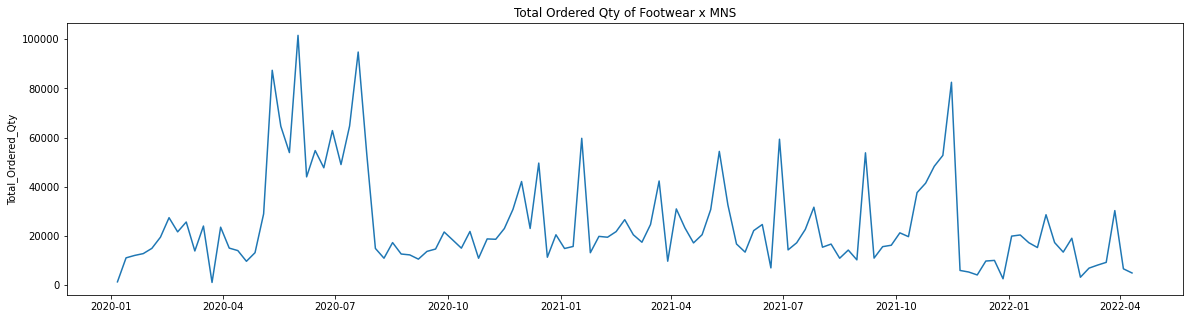

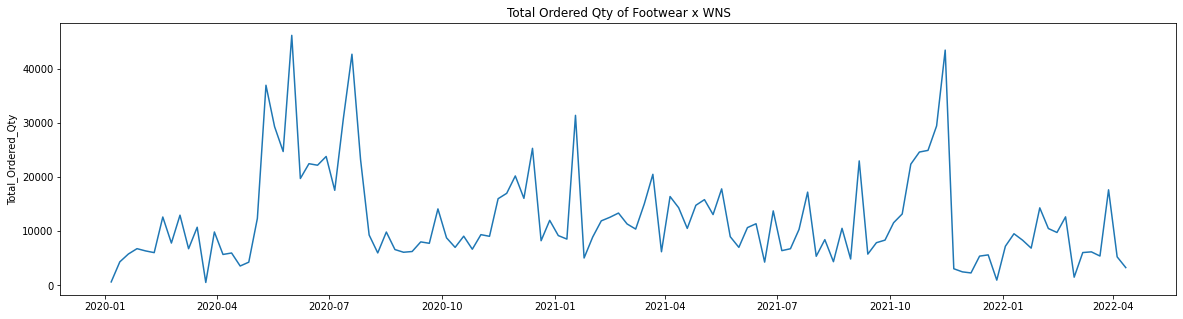

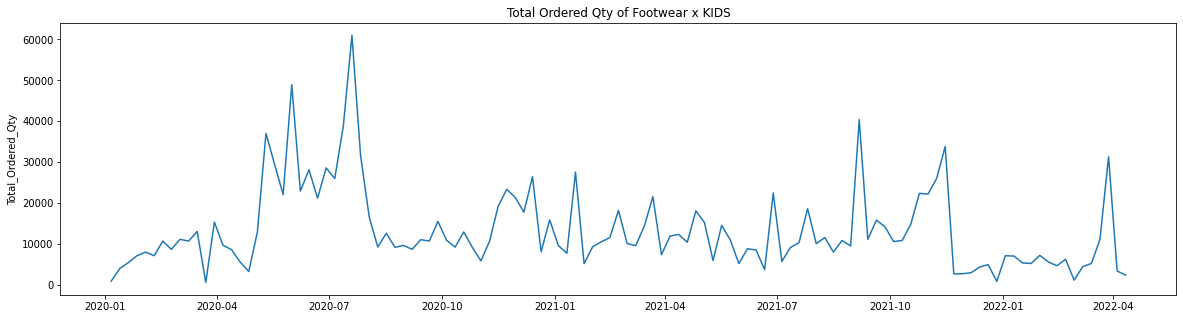

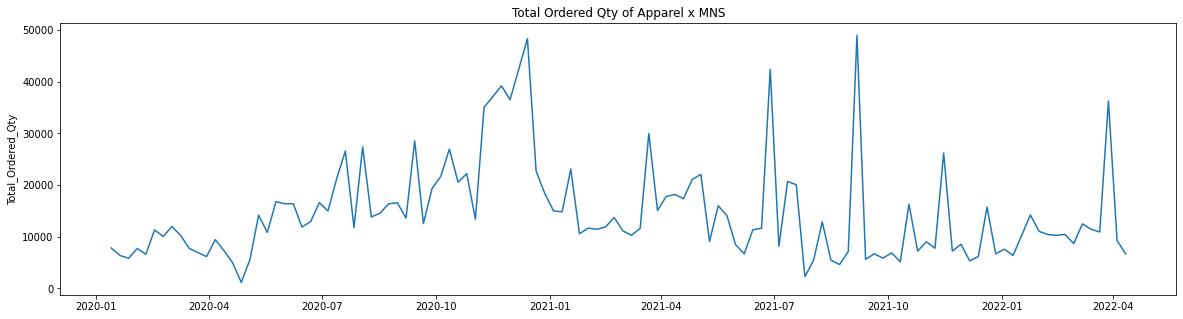

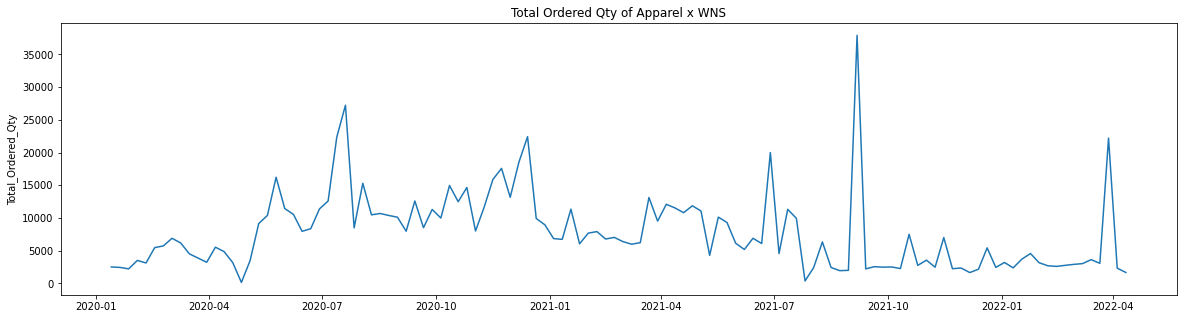

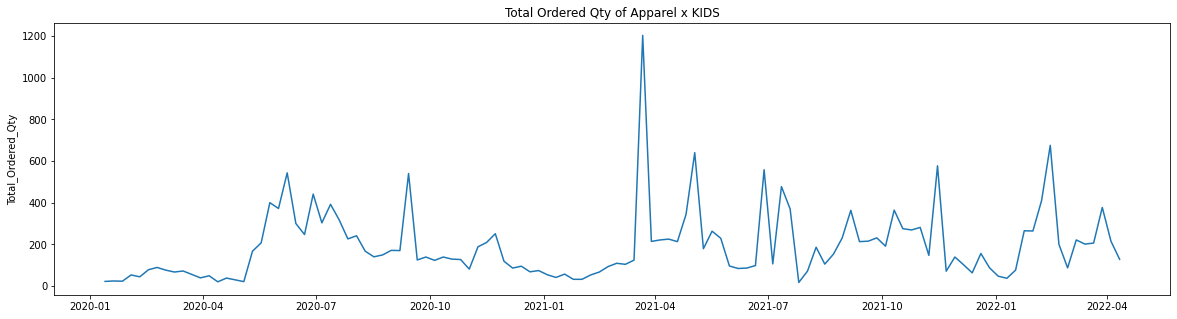

In [23]:
order_ts('Product_Division','Footwear','ERP_Master_Gender','MNS')
order_ts('Product_Division','Footwear','ERP_Master_Gender','WNS')
order_ts('Product_Division','Footwear','ERP_Master_Gender','KIDS')
order_ts('Product_Division','Apparel','ERP_Master_Gender','MNS')
order_ts('Product_Division','Apparel','ERP_Master_Gender','WNS')
order_ts('Product_Division','Apparel','ERP_Master_Gender','KIDS')

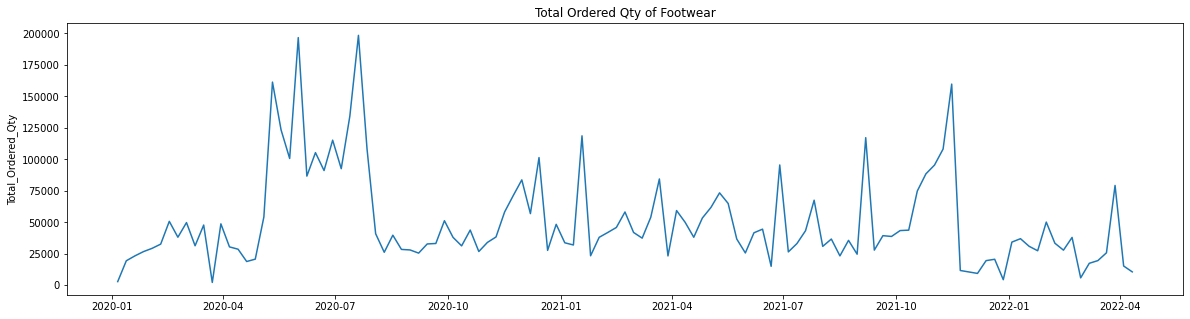

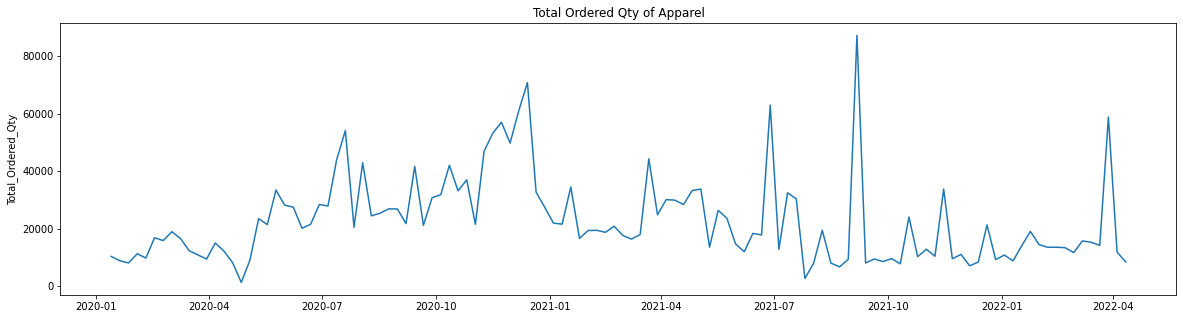

In [24]:
order_ts('Product_Division','Footwear','','')
order_ts('Product_Division','Apparel','','')

## ARIMA Model

In [25]:
df_1 = df.copy()
df = df_1.copy()

In [28]:
df = df[df['Product_Division'] == 'Footwear'].groupby(['Year_Week'])['Total_Ordered_Qty'].sum()

In [30]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pylab import rcParams
import itertools
import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 20, 7

In [31]:
# split data into training set and test set
q_80 = int(119 * 0.8)
train, test = df[:q_80], df[q_80:]
print(train.shape)
print(test.shape)

(95,)
(24,)


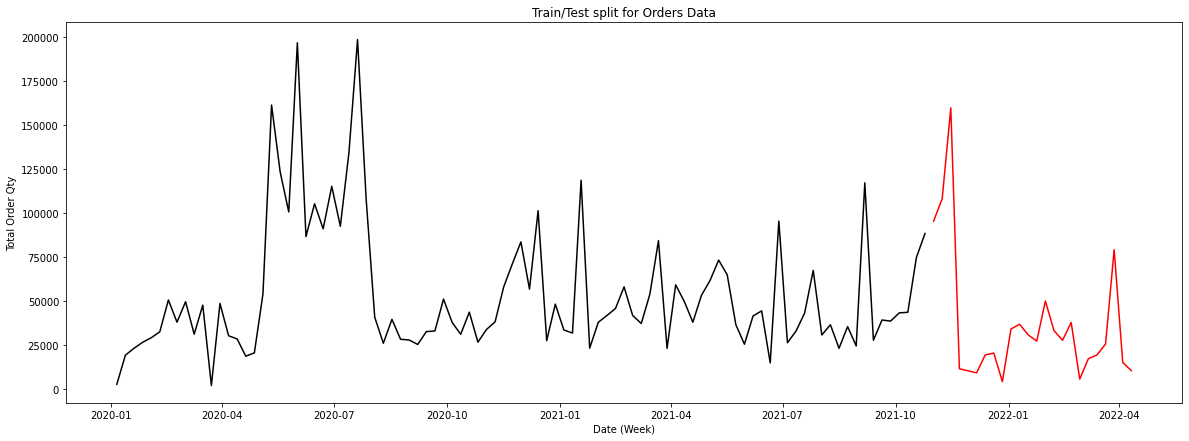

In [32]:
# plot the training set and test set
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split for Orders Data")
plt.ylabel("Total Order Qty")
plt.xlabel("Date (Week)")
plt.show()

In [33]:
# Stationarity Test
result = adfuller(train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# p-value is less than 0.05, the time series in training set is stationary.

ADF Statistic: -3.855739
p-value: 0.002386


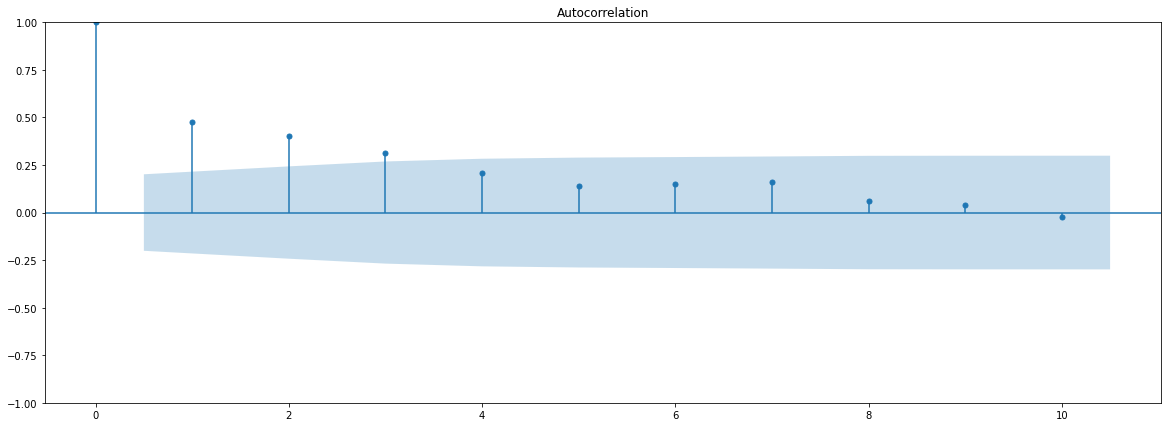

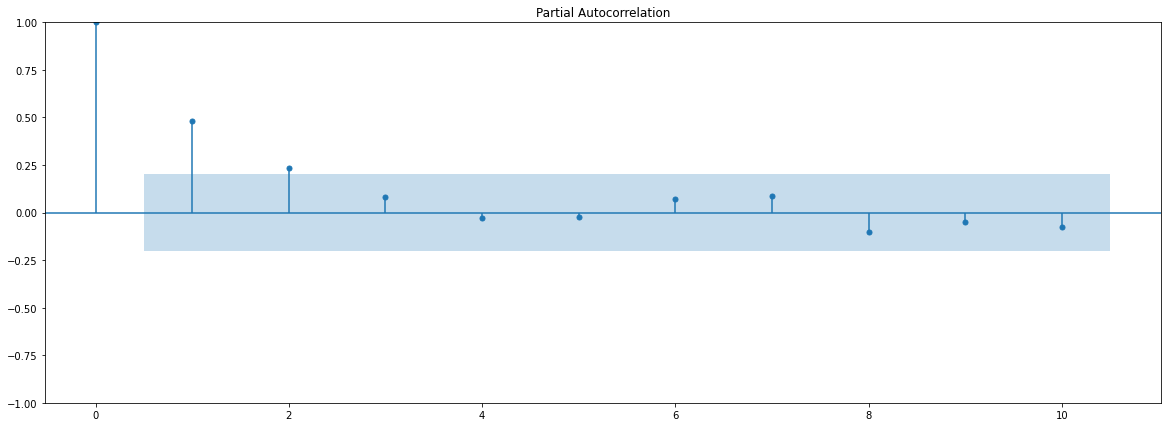

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot autocorrelation
plot_acf(train,lags=10).show()
# Plot partial autocorrelation
plot_pacf(train,lags=10).show()
plt.show()

In [36]:
def sarima_grid_search(y):
    p = q = range(0, 4)
    d = [0]
    pdq = list(itertools.product(p, d, q))
    mini = float(np.inf)
    for param in pdq:
        try:
            mod = ARIMA(y, order=param)
            results = mod.fit()

            if results.aic < mini:
                mini = results.aic
                param_mini = param

        except:
            continue
    print('The set of parameters with the minimum AIC is: ARIMA{} - AIC:{}'.format(param_mini, mini))

In [37]:
sarima_grid_search(train)

The set of parameters with the minimum AIC is: ARIMA(1, 0, 1) - AIC:2245.0335064566025


In [38]:
mod = ARIMA(train, order=(1,0,1))
results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:      Total_Ordered_Qty   No. Observations:                   95
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1118.517
Date:                Sun, 03 Jul 2022   AIC                           2245.034
Time:                        07:56:15   BIC                           2255.249
Sample:                    01-06-2020   HQIC                          2249.161
                         - 10-25-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.396e+04   9833.330      5.488      0.000    3.47e+04    7.32e+04
ar.L1          0.7971      0.085      9.325      0.000       0.630       0.965
ma.L1         -0.4188      0.151     -2.782      0.0

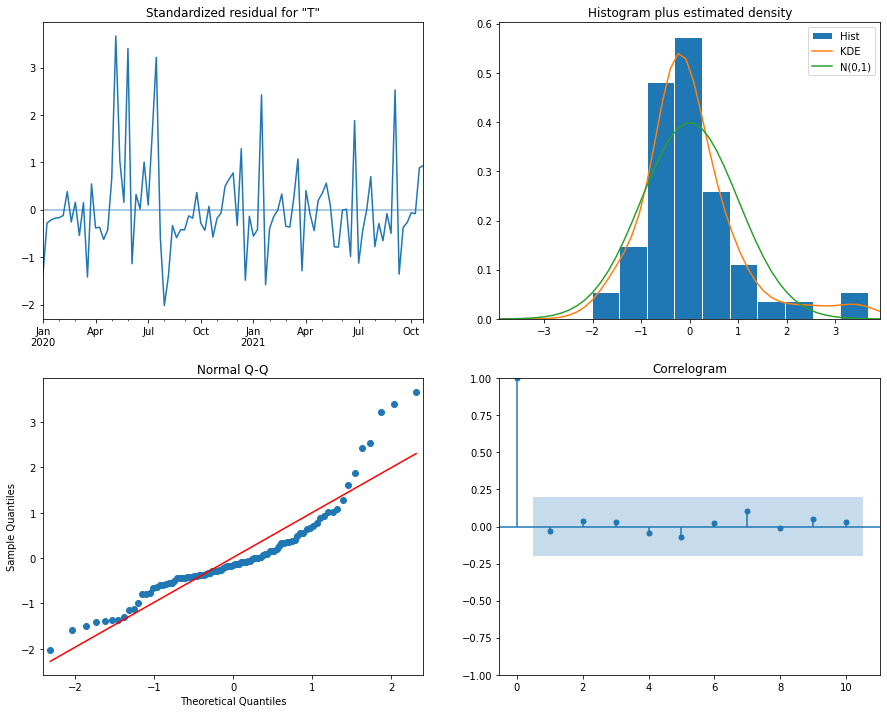

In [39]:
# Model diagnosis
results.plot_diagnostics(figsize=(15, 12))
plt.show()

[69108.82865044 66036.01398978 63586.69410517 61634.35771016
 60078.16350978 58837.73158654 57848.99164918 57060.87369977
 56432.67018667 55931.93339447 55532.79946759 55214.65250082
 54961.05969488 54758.92257606 54597.80043912 54469.37106818
 54367.000881   54285.40229379 54220.36060912 54168.51632003
 54127.19158614 54094.25191888 54067.99593181 54047.06746123]


Text(0.5, 1.0, 'Forecast vs Actuals')

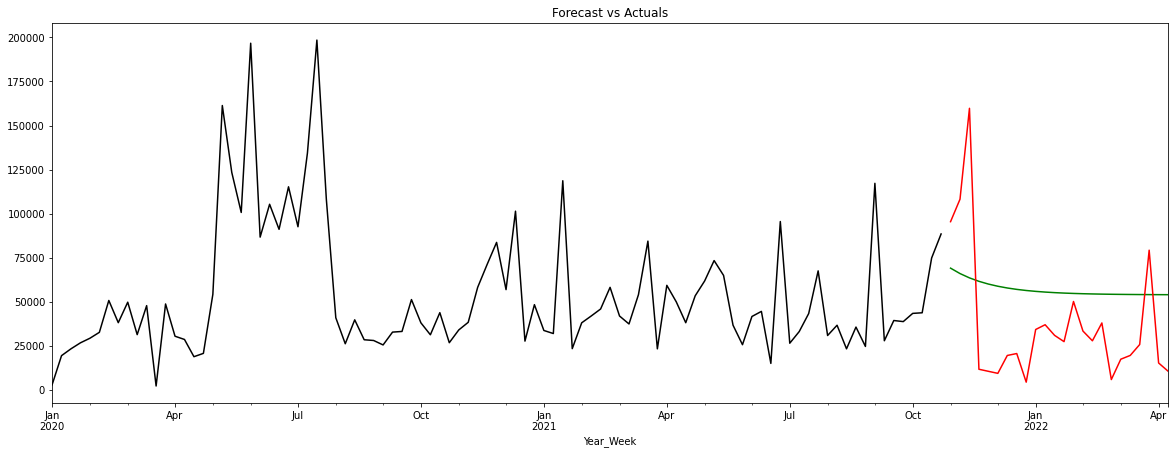

In [41]:
# Validation
mod = ARIMA(train, order=(1,0,1))
result = mod.fit()
predict_sunspots = result.forecast(len(test))
forcast = np.array(predict_sunspots[:]).reshape(-1)
print(forcast)

train.plot(color = "black")
predict_sunspots.plot(color = "green") # prediction results are green
test.plot(color = "red") # actual values are red
plt.title('Forecast vs Actuals')

In [42]:
# MSE & RMSE
mse = ((predict_sunspots.iloc[1] - test) ** 2).mean()
rmse = np.sqrt(mse)
print('The MSE of the predictive results is：{}'.format(round(mse, 2)))
print('The RMSE of the predictive results is：{}'.format(round(rmse, 2)))

The MSE of the predictive results is：2182090394.46
The RMSE of the predictive results is：46712.85


In [46]:
mod = ARIMA(df, order=(1,0,1))
results = mod.fit()
forecast = results.get_forecast(steps= 40)
df_forecast = forecast.predicted_mean
df_forecast

2022-04-18    30078.944446
2022-04-25    34856.057948
2022-05-02    38520.344958
2022-05-09    41331.037916
2022-05-16    43486.981184
2022-05-23    45140.698414
2022-05-30    46409.182941
2022-06-06    47382.174554
2022-06-13    48128.508198
2022-06-20    48700.983747
2022-06-27    49140.101368
2022-07-04    49476.926733
2022-07-11    49735.288776
2022-07-18    49933.465495
2022-07-25    50085.477034
2022-08-01    50202.077552
2022-08-08    50291.516030
2022-08-15    50360.119854
2022-08-22    50412.742448
2022-08-29    50453.106631
2022-09-05    50484.067996
2022-09-12    50507.816924
2022-09-19    50526.033550
2022-09-26    50540.006621
2022-10-03    50550.724671
2022-10-10    50558.945956
2022-10-17    50565.252096
2022-10-24    50570.089224
2022-10-31    50573.799545
2022-11-07    50576.645548
2022-11-14    50578.828576
2022-11-21    50580.503069
2022-11-28    50581.787489
2022-12-05    50582.772704
2022-12-12    50583.528414
2022-12-19    50584.108081
2022-12-26    50584.552716
2

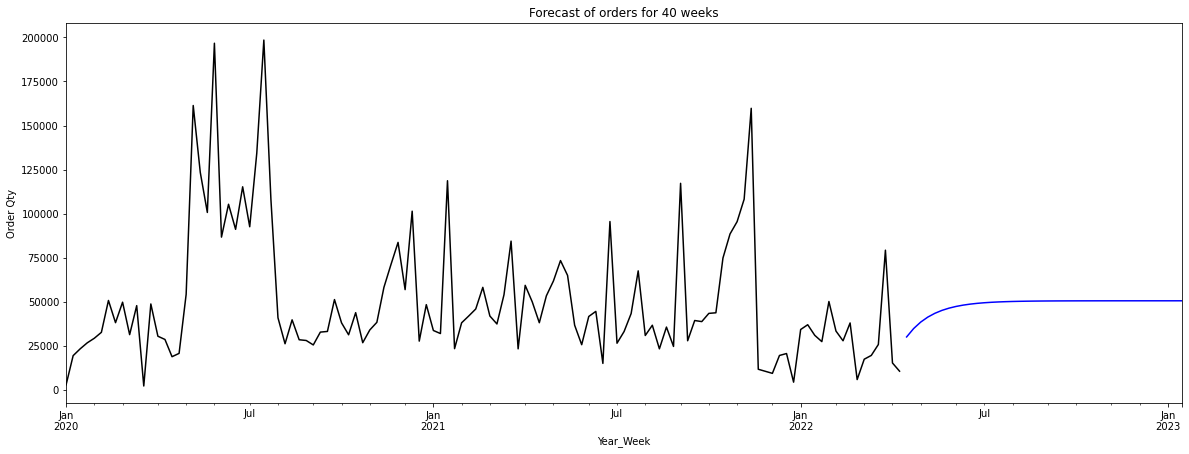

In [47]:
df_forecast.plot(color = "blue")
df.plot(color = "black")
plt.title("Forecast of orders for 40 weeks")
plt.ylabel("Order Qty")
plt.show()

In [48]:
from pmdarima.arima import auto_arima
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 5

In [49]:
df = df_1.copy()

In [50]:
df = df[df['Product_Division'] == 'Footwear']

In [51]:
def arima_pred(train, test):
    model = auto_arima(train, start_p=0, start_q=0, test='adf',
                          max_p=5, max_d=2, max_q=5,
                          seasonal=False, start_P=0, D=None,
                          error_action='ignore', suppress_warnings=True, stepwise=True)

    prediction = pd.DataFrame(model.predict(n_periods=len(test)), index=test.index)
    return prediction

In [52]:
# Univariate Traversal and Split
def single_group_prediction(data, model, val, group):
    q_80 = int(119 * 0.8)
    selected_train, selected_test, final_pred = [], [], []
    
    for g in group:
        grouped = data[data[val]==g].groupby(['Year_Week'])['Total_Ordered_Qty'].sum()
        if grouped.shape[0] == 119:
            grouped_train, grouped_test = grouped[:q_80], grouped[q_80:]
            selected_train.append(grouped_train)
            selected_test.append(grouped_test)
            
            final_pred.append(model(grouped_train, grouped_test))
            
    return sum(selected_train), sum(selected_test), sum(final_pred)

In [ ]:
gender = ['WNS', 'MNS', 'KIDS']
ussize = ['7', '7.5', '8', '8.5', '9', '9.5', '10', '10.5', '11', '11.5', '12']
color = ['black', 'white', 'blue', 'gray', 'pink', 'red']

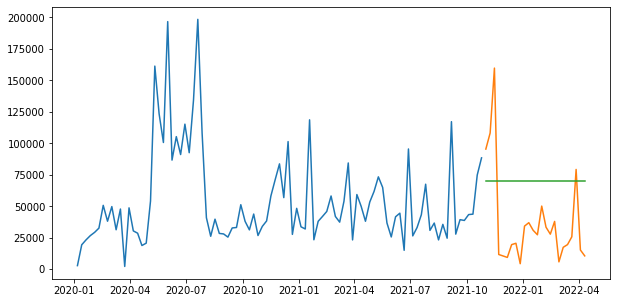

In [57]:
# grouped by gender
train, test, final_pred = single_group_prediction(df, arima_pred, 'ERP_Master_Gender', gender)

plt.plot(train)
plt.plot(test)
plt.plot(final_pred)

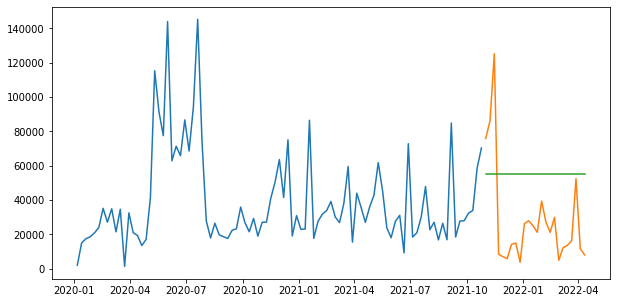

In [58]:
# grouped by us size
train, test, final_pred = single_group_prediction(df, arima_pred, 'US_Size', ussize)

plt.plot(train)
plt.plot(test)
plt.plot(final_pred)

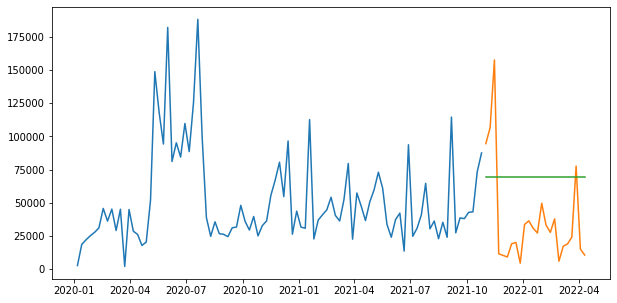

In [59]:
# grouped by color
train, test, final_pred = single_group_prediction(df, arima_pred, 'Main_Color_Group_Desc', color)

plt.plot(train)
plt.plot(test)
plt.plot(final_pred)

In [62]:
# Bivariate Traversal and Split
def two_group_prediction(data, model, val1, group1, val2, group2):
    q_80 = int(119 * 0.8)
    selected_train, selected_test, final_pred = [], [], []
    
    for g1 in group1:
        for g2 in group2:
            grouped = data[(data[val1]==g1) & (data[val2]==g2)].groupby(['Year_Week'])['Total_Ordered_Qty'].sum()
            if grouped.shape[0] == 119:
                grouped_train, grouped_test = grouped[:q_80], grouped[q_80:]
                selected_train.append(grouped_train)
                selected_test.append(grouped_test)
                
                final_pred.append(model(grouped_train, grouped_test))

    return sum(selected_train), sum(selected_test), sum(final_pred)

In [63]:
gender = ['WNS', 'MNS', 'KIDS']
ussize = ['7', '7.5', '8', '8.5', '9', '9.5', '10', '10.5', '11', '11.5', '12']
color = ['black', 'white', 'blue', 'gray', 'pink', 'red']

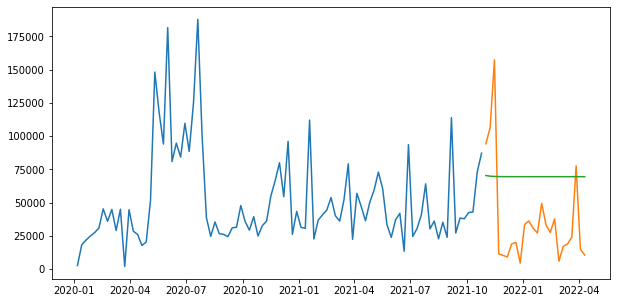

In [64]:
# grouped by gender x color
train, test, final_pred = two_group_prediction(df, arima_pred, 
                                               'ERP_Master_Gender', gender,
                                               'Main_Color_Group_Desc', color)
plt.plot(train)
plt.plot(test)
plt.plot(final_pred)

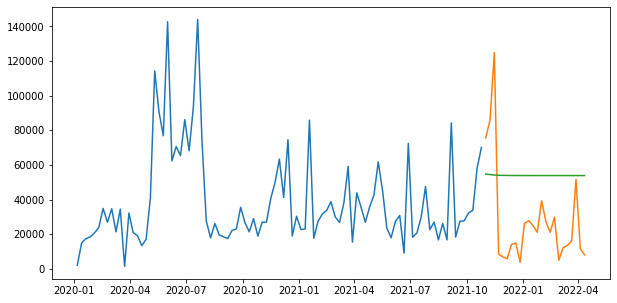

In [65]:
# grouped by gender x us size
train, test, final_pred = two_group_prediction(df, arima_pred, 
                                               'ERP_Master_Gender', gender,
                                               'US_Size', ussize)
plt.plot(train)
plt.plot(test)
plt.plot(final_pred)

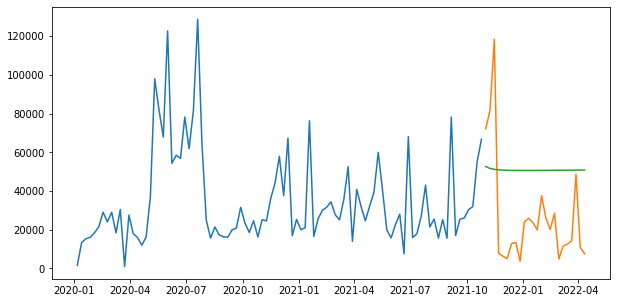

In [66]:
# grouped by color x us size
train, test, final_pred = two_group_prediction(df, arima_pred, 
                                               'Main_Color_Group_Desc', color,
                                               'US_Size', ussize)
plt.plot(train)
plt.plot(test)
plt.plot(final_pred)

## LSTM Network

In [88]:
df = df_1.copy()

In [68]:
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [89]:
df = df[df['Product_Division'] == 'Footwear'].groupby(['Year_Week'])['Total_Ordered_Qty'].sum()

In [90]:
df.head(5)

Year_Week
2020-01-06     2910.0
2020-01-13    19469.0
2020-01-20    23349.0
2020-01-27    26747.0
2020-02-03    29340.0
Name: Total_Ordered_Qty, dtype: float64

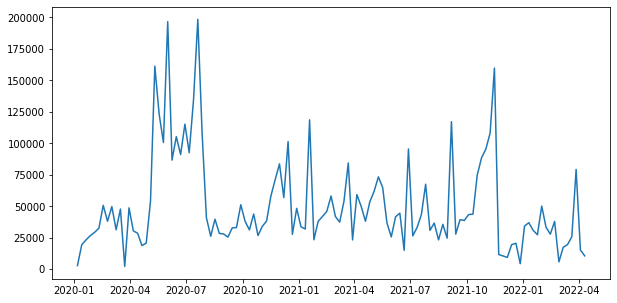

In [91]:
plt.plot(df)

In [92]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n):
    first_date = pd.to_datetime(first_date_str)
    last_date  = pd.to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset.values
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

# Start day second time around: '2020-02-03'
windowed_df = df_to_windowed_df(df, 
                                '2020-02-03', 
                                '2022-04-11', 
                                4)
windowed_df

,Target Date,Target-4,Target-3,Target-2,Target-1,Target
0,2020-02-03,2910.0,19469.0,23349.0,26747.0,29340.0
1,2020-02-10,19469.0,23349.0,26747.0,29340.0,32696.0
2,2020-02-17,23349.0,26747.0,29340.0,32696.0,50772.0
3,2020-02-24,26747.0,29340.0,32696.0,50772.0,38171.0
4,2020-03-02,29340.0,32696.0,50772.0,38171.0,49790.0
...,...,...,...,...,...,...
110,2022-03-14,27898.0,38013.0,5897.0,17448.0,19595.0
111,2022-03-21,38013.0,5897.0,17448.0,19595.0,25790.0
112,2022-03-28,5897.0,17448.0,19595.0,25790.0,79296.0
113,2022-04-04,17448.0,19595.0,25790.0,79296.0,15306.0


In [93]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()
    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
    Y = df_as_np[:, -1]
    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((115,), (115, 4, 1), (115,))

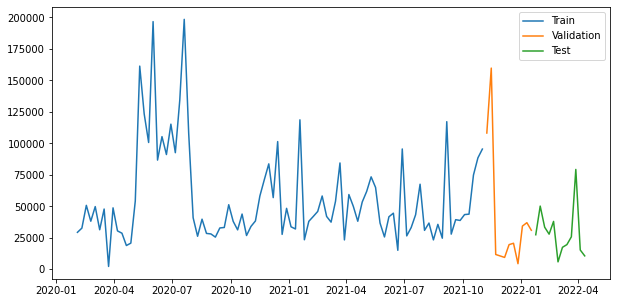

In [94]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [95]:
X_train.shape[1]

4

In [96]:
model = Sequential([layers.Input((X_train.shape[1], X_train.shape[2])),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.01),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
3/3 [==============================] - 6s 612ms/step - loss: 4494050816.0000 - mean_absolute_error: 55973.3477 - val_loss: 3810239232.0000 - val_mean_absolute_error: 40606.6523
Epoch 2/100
3/3 [==============================] - 0s 34ms/step - loss: 4493794304.0000 - mean_absolute_error: 55971.0234 - val_loss: 3809978112.0000 - val_mean_absolute_error: 40603.4414
Epoch 3/100
3/3 [==============================] - 0s 34ms/step - loss: 4493378048.0000 - mean_absolute_error: 55967.2344 - val_loss: 3809560832.0000 - val_mean_absolute_error: 40598.2969
Epoch 4/100
3/3 [==============================] - 0s 33ms/step - loss: 4492690432.0000 - mean_absolute_error: 55961.3086 - val_loss: 3808932096.0000 - val_mean_absolute_error: 40590.5469
Epoch 5/100
3/3 [==============================] - 0s 34ms/step - loss: 4491720704.0000 - mean_absolute_error: 55952.5508 - val_loss: 3808028928.0000 - val_mean_absolute_error: 40579.4258
Epoch 6/100
3/3 [==============================] - 0s 36ms/

3/3 [==============================] - 0s 35ms/step - loss: 1361152128.0000 - mean_absolute_error: 27562.7656 - val_loss: 2401437952.0000 - val_mean_absolute_error: 43820.4531
Epoch 87/100
3/3 [==============================] - 0s 31ms/step - loss: 1361053568.0000 - mean_absolute_error: 27579.0820 - val_loss: 2401673216.0000 - val_mean_absolute_error: 43825.2930
Epoch 88/100
3/3 [==============================] - 0s 34ms/step - loss: 1361330304.0000 - mean_absolute_error: 27597.7773 - val_loss: 2403643648.0000 - val_mean_absolute_error: 43865.6523
Epoch 89/100
3/3 [==============================] - 0s 33ms/step - loss: 1361262208.0000 - mean_absolute_error: 27594.0293 - val_loss: 2401641216.0000 - val_mean_absolute_error: 43824.6367
Epoch 90/100
3/3 [==============================] - 0s 31ms/step - loss: 1361090432.0000 - mean_absolute_error: 27583.4883 - val_loss: 2401840128.0000 - val_mean_absolute_error: 43828.7148
Epoch 91/100
3/3 [==============================] - 0s 33ms/step - l

In [97]:
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()

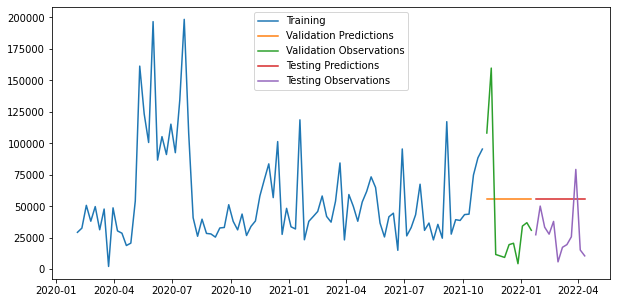

In [100]:
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])